# explore whistler in cold and hot plasmas

In [1]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.dispersion_tensor import f_epsilon, f_chi, f_yn
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import interpolate

from py_vlasov.util import (pmass, emass, echarge, permittivity, permeability, cspeed, boltzmann)

mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5
mpl.rcParams['xtick.major.width'] = 1.1
mpl.rcParams['ytick.major.width'] = 1.1
mpl.rcParams['xtick.minor.width'] = .8
mpl.rcParams['ytick.minor.width'] = .8
#xtick.major.size     : 3.5      # major tick size in points
#xtick.minor.size     : 2      # minor tick size in points
#xtick.major.width    : 0.8    # major tick width in points
#xtick.minor.width    : 0.6    # minor tick width in points
%matplotlib inline

ModuleNotFoundError: No module named 'py_vlasov'

In [2]:
def fast_freq_fn(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

def whistler_freq_fn(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return 1836 * kdi**2 / (1836 + kdi**2) * cos_theta   

def alfven_freq_fn(k, theta, betap):
    kz, kp = kzkp(k, theta)
    return kz / np.sqrt(betap)

def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

def krhoi_2_kdi(krhoi, betap):
    return krhoi / np.sqrt(betap)

def krhoi_2_kde(krhoi, betap):
    return krhoi / np.sqrt(betap) / np.sqrt(1836)

## plasma parameters
$T_e = 5$ KeV

$T_p = 100$ eV

$n = 2 cm^{-3}$

$B_0 = 30nT$

In [3]:
def beta_f(n, t, b0):
    """
    Calculate plasma beta.
    parameters
    ----------
        n: density in cc
        t: temperature in eV
        b0: magnetic field in nT
        
    return
    ------
        beta = 2mu_0 n k_B t / b0^2
    """
    return 2 * permeability * n * 1e6 * t * echarge / (b0 * 1e-9)**2

In [13]:
n = 3 # cc
tp = 100 # eV
# te = 5e3 # eV
te = 100 # eV
# b0 = 30 # nT
b0 = 90
betap = beta_f(n, tp, b0)

In [14]:
betap

0.014913736717231679

In [15]:
tetp = te/tp # hot electron
# tetp = 1 # cold electron
t_list=[1.,tetp]
a_list=[1., 1.]
n_list=[1.,1.] 
q_list=[1.,-1.]
m_list=[1., 1./1836.]
v_list=[0.,0.]
n = 6
wpe_wce = 5
aol = 1/wpe_wce / np.sqrt(1836)
print('aol={0:.3g}'.format(aol))
method = 'pade'

theta = 15

k = 1
kz, kp = kzkp(k, theta)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

aol=0.00467


In [16]:
# WHISTLER MODE

whistler_seed_freq = fast_freq_fn(k, theta, betap)
f = lambda wrel:\
    real_imag(disp_det(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = 'pade', n = 10, \
                              aol=aol))
whistler_guess = whistler_seed_freq 
print('whistler_seed_freq = {0:.3g}'.format(whistler_guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(whistler_guess))

print('wr = {0:.3g}'.format(wr))
print('wi = {0:.3g}'.format(wi))
print(r'wr/Omega_e = {0:.3g}'.format(wr/1836/np.cos(np.deg2rad(theta))))

whistler_seed_freq = 65.3
wr = 63.4
wi = -0.0314
wr/Omega_e = 0.0357


## dispersion relation

In [17]:
target_k = 50
whistler_freq = follow_k(whistler_guess, target_k, param,
                log_incrmt = 0.02, incrmt_method = 'log')

In [18]:
freq_i_arr = np.array(whistler_freq[-1])
krhoi_arr = np.logspace(np.log10(k), np.log10(target_k), len(freq_i_arr))
kde_arr = np.array([krhoi_2_kde(k, betap) for k in krhoi_arr])
freq_e_arr = freq_i_arr / 1836 / np.cos(np.deg2rad(theta))

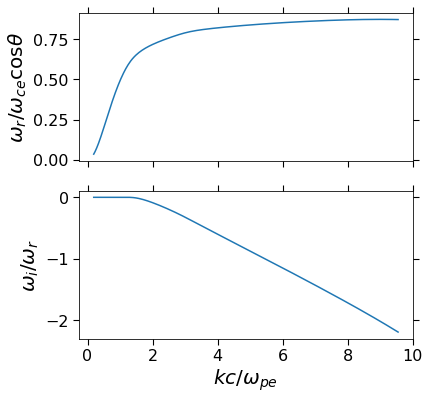

In [19]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=[6,6])
ax = axes[0]
ax.plot(kde_arr, freq_e_arr.real)
ax.set_ylabel(r'$\omega_r/\omega_{ce}\cos\theta$')

ax = axes[1]
ax.plot(kde_arr, freq_e_arr.imag/freq_e_arr.real)
ax.set_ylabel(r'$\omega_i/\omega_r$')
ax.set_xlabel(r'$kc/\omega_{pe}$')


## transport ratio

In [20]:
def get_transport_ratios(k_list, freq_arr):
    ex_ez_list = []
    ey_ez_list = []
    by_bx_list = []
    
    eigen_e_list = []
    eigen_b_list = []
    dt_list = []

    for i in range(len(k_list)):
        freq_i = freq_arr[i]
        kz, kp = kzkp(k_list[i], theta)
#         inp = input_gen(freq_i, kp, kz, betap)
        inp = input_gen(freq_i, kz, kp, betap, t_list, \
              a_list, n_list, q_list, m_list, v_list, \
              n, method = method, aol=aol)
    
        tr = transport_ratios(inp, print_result = False)
        eigen_e = tr['eigen_e']
        kvec = np.array([kp, 0, kz])
        khat = kvec/np.linalg.norm(kvec)
        ez_prime = np.dot(eigen_e, khat) * khat
        ey_prime = np.array([0, eigen_e[1], 0])
        ex_prime = eigen_e - ez_prime - ey_prime
        ex_ez = np.linalg.norm(ex_prime) / np.linalg.norm(ez_prime)
        ey_ez = np.linalg.norm(ey_prime) / np.linalg.norm(ez_prime)
        ex_ez_list.append(ex_ez)
        ey_ez_list.append(ey_ez)
        
        eigen_e_list.append(eigen_e)

        eigen_b = np.cross(kvec, eigen_e)
        bz_prime = np.dot(eigen_b, khat) * khat
        by_prime = np.array([0, eigen_b[1], 0])
        bx_prime = eigen_b - bz_prime - by_prime
        by_bx = np.linalg.norm(bx_prime) / np.linalg.norm(by_prime)
        by_bx_list.append(by_bx)
        
        eigen_b_list.append(eigen_b)
    return {'exez': ex_ez_list, 'eyez': ey_ez_list, 'bybx': by_bx_list, 'eigen_e':eigen_e_list, 'eigen_b':eigen_b_list}


def wave_energy(wrel, kz, kp, betap, t_list, a_list, n_list, q_list, m_list, v_list, n, method='pade', aol=1e-4, normalizeB=True):
    """
    Parameters
    ----------
        
        
    Return
    ------
        wave energy in arbitray unit (since amplitude of E is arbitrary).
        see Stix 1992, Chp 4, Eq. (20)
    """
    def helper(wrel):
        return input_gen(wrel, kz, kp, betap, t_list, \
                         a_list, n_list, q_list, m_list, v_list, \
                         n, method = method, aol=aol) 
    inp = helper(wrel)
    OmegaP = inp[0][-3]
#     print('omegaP = {0:.3g}'.format(OmegaP))
    tr = transport_ratios(inp, print_result = False)
    eigenE = tr['eigen_e']
    kVec = np.array([kp, 0, kz])
    eigenB = -np.cross(kVec, eigenE)/wrel
    # if E is in unit of statV/cm, B is in unit Gauss
    eigenB = eigenB / aol / np.sqrt(betap)
    
    wr = wrel.real
    dw = abs(wr * 1e-3)
    wrPlus = wr + dw
    wrMinus = wr - dw
    
    def getParam(w):
        inp = helper(w)
        return list(map(list, zip(*inp)))
    
    epsilonWr = f_epsilon(getParam(wr)) / (wr * OmegaP)**2
    epsilonWrPlus = f_epsilon(getParam(wrPlus)) / (wrPlus * OmegaP)**2
    epsilonWrMinus = f_epsilon(getParam(wrMinus)) / (wrMinus * OmegaP)**2
    
    # hermitian component
    epsilonHWr = (epsilonWr + np.conjugate(epsilonWr.T))/2
    epsilonHWrPlus = (epsilonWrPlus + np.conjugate(epsilonWrPlus.T))/2
    epsilonHWrMinus = (epsilonWrMinus + np.conjugate(epsilonWrMinus.T))/2

    wEpsilonPrime = epsilonHWr + wr * (epsilonHWrPlus - epsilonHWrMinus) / (2 * dw)
    
    bEnergy = np.linalg.norm(eigenB)**2
    waveEnergy = np.dot(np.conjugate(eigenE), np.dot(wEpsilonPrime, eigenE))
    waveEnergy += bEnergy
    waveEnergy *= 1/(16*np.pi)
    if normalizeB:
        waveEnergy /= bEnergy
    return waveEnergy
   
    
def get_wave_energy(krhoi_arr, freq_i_arr):
    waveEnergyArr = []
    for i in range(len(krhoi_arr)):
        wrel = freq_i_arr[i]
        kz, kp = kzkp(krhoi_arr[i], theta)
        energy = wave_energy(wrel, kz, kp, betap, t_list, a_list, 
                             n_list, q_list, m_list, v_list, n, 
                             method=method, aol=aol, normalizeB=True)
        waveEnergyArr.append(energy.real)
    return waveEnergyArr

In [21]:
# j = 50
# wrj = freq_i_arr[j]
# kj = krhoi_arr[j]
# kzj, kpj = kzkp(kj, theta)
# wej = wave_energy(wrj, kzj, kpj, betap, t_list, a_list, n_list, q_list, m_list, v_list, n, method=method, aol=aol)
# print(wej)
# print(wej.imag/wej.real)

In [22]:
we = get_wave_energy(krhoi_arr, freq_i_arr)

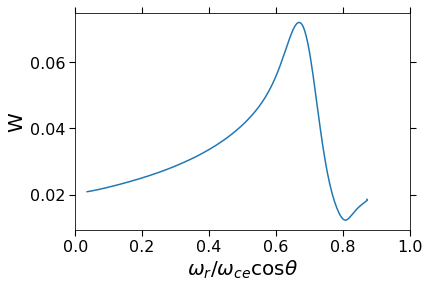

In [23]:
plt.plot(freq_e_arr.real, we)
plt.xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')
plt.ylabel(r'W')
plt.xlim([0, 1.0])
# plt.ylim([0, 2])
plt.show()

In [24]:
whistler_tr = get_transport_ratios(krhoi_arr, freq_i_arr)

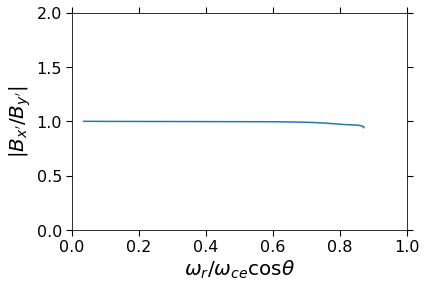

In [25]:
plt.plot(freq_e_arr.real, whistler_tr['bybx'])
plt.xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')
plt.ylabel(r'$|B_{x^\prime}/B_{y^\prime}|$')
plt.xlim([0, 1.0])
plt.ylim([0, 2])
plt.show()

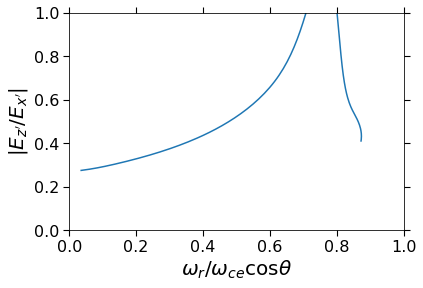

In [26]:
plt.plot(freq_e_arr.real, 1/np.array(whistler_tr['eyez']))
plt.xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')
plt.ylabel(r'$|E_{z^\prime}/E_{x^\prime}|$')
plt.xlim([0, 1.0])
plt.ylim([0, 1])
plt.show()

In [27]:
save_arr = np.zeros((6, len(freq_e_arr)))

In [28]:
save_arr[0, :] = kde_arr
save_arr[1, :] = freq_e_arr.real
save_arr[2, :] = freq_e_arr.imag
save_arr[3, :] = whistler_tr['bybx']
save_arr[4, :] = 1/np.array(whistler_tr['eyez'])
save_arr[5, :] = we

In [29]:
filename = 'data/whistler_cold_hot/whistler_hot_b90_te100_n3_theta_15'
np.save(filename, save_arr)

In [329]:
!ls data/whistler_cold_hot/

whistler_cold_b90_te1500_n3_theta_15.npy
whistler_cold_b90_te1500_n3_theta_30.npy
whistler_cold_b90_te1500_n3_theta_45.npy
whistler_cold_b90_te1500_n3_theta_5.npy
whistler_cold_b90_te3000_n3_theta_15.npy
whistler_cold_b90_te3000_n3_theta_30.npy
whistler_cold_b90_te3000_n3_theta_45.npy
whistler_cold_b90_te3000_n3_theta_5.npy
whistler_cold_b90_te500_n3_theta_15.npy
whistler_cold_b90_te500_n3_theta_30.npy
whistler_cold_b90_te500_n3_theta_45.npy
whistler_cold_b90_te500_n3_theta_5.npy
whistler_cold_b90_te500_theta_15.npy
whistler_cold_b90_te500_theta_30.npy
whistler_cold_b90_te500_theta_45.npy
whistler_cold_b90_te500_theta_5.npy
whistler_cold_b90_theta_15.npy
whistler_cold_b90_theta_30.npy
whistler_cold_b90_theta_45.npy
whistler_cold_theta_15.npy
whistler_cold_theta_30.npy
whistler_cold_theta_45.npy
whistler_hot_b90_te1500_n3_theta_15.npy
whistler_hot_b90_te1500_n3_theta_30.npy
whistler_hot_b90_te1500_n3_theta_45.npy
whistler_hot_b90_te1500_n3_theta_5.npy
whistler_hot_b90_te3000_n3_theta_15

In [330]:
# np.load(filename + '.npy')

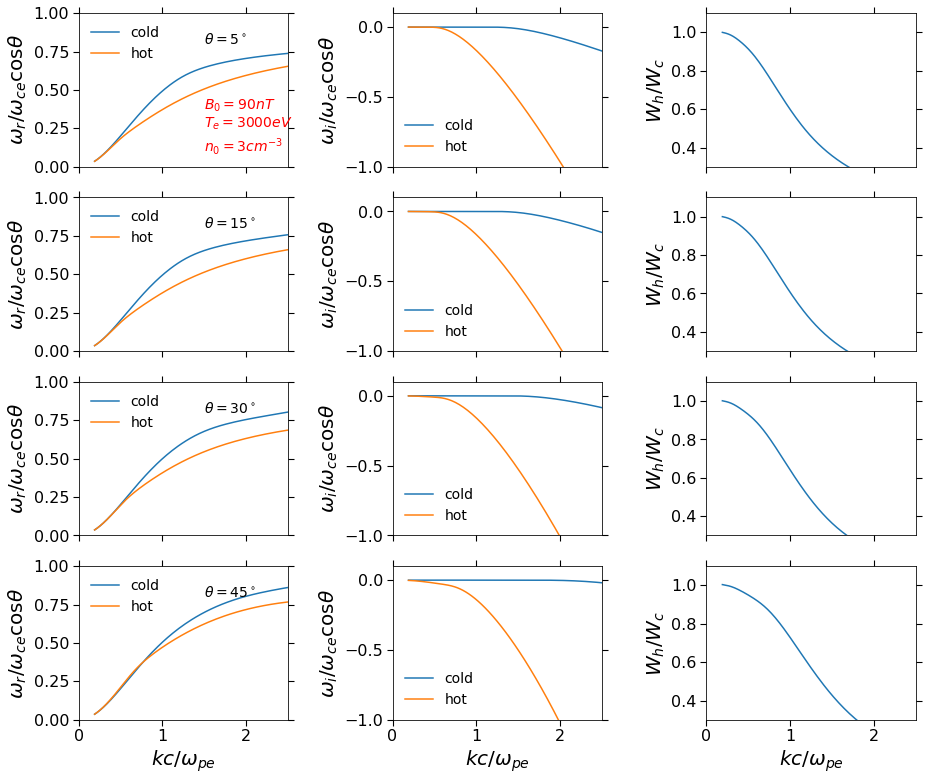

In [349]:
fig, axes = plt.subplots(4, 3, sharex=True, figsize = [15, 13], gridspec_kw={'wspace': .5})

temp_arr = [5, 15, 30, 45]

for i in range(4):
    
    cold_file = 'data/whistler_cold_hot/whistler_cold_b90_te3000_n3_theta_{0}.npy'.format(temp_arr[i])
    hot_file = 'data/whistler_cold_hot/whistler_hot_b90_te3000_n3_theta_{0}.npy'.format(temp_arr[i])
    cold_data = np.load(cold_file)
    hot_data = np.load(hot_file)

    ax = axes[i][0]

    ax.plot(cold_data[0, :], cold_data[1, :], label = 'cold')
    ax.plot(hot_data[0, :], hot_data[1, :], label = 'hot')
    ax.legend(loc='best', frameon=False, fontsize = 14)
    ax.set_ylabel(r'$\omega_r/\omega_{ce}\cos\theta$')
    ax.set_xlim([0, 2.5])
    ax.set_ylim([0, 1.])
    ax.text(1.5, .8, r'$\theta = {}^\circ$'.format(temp_arr[i]), fontsize = 14)

    ax = axes[i][1]
    ax.plot(cold_data[0, :], cold_data[2, :], label = 'cold')
    ax.plot(hot_data[0, :], hot_data[2, :], label = 'hot')
    ax.legend(loc='best', frameon=False, fontsize = 14)
    ax.set_ylabel(r'$\omega_i/\omega_{ce}\cos\theta$')
    ax.set_ylim([-1, 0.1])
    
    ax = axes[i][2]
    ax.plot(cold_data[0, :], hot_data[4, :] / cold_data[4, :])
    ax.set_ylabel(r'$W_{h}/W_{c}$')
    ax.set_ylim([0.3, 1.1])
    
axes[3][0].set_xlabel(r'$kc/\omega_{pe}$')
axes[3][1].set_xlabel(r'$kc/\omega_{pe}$')
axes[3][2].set_xlabel(r'$kc/\omega_{pe}$')

text = ''
text += r'$B_0=90nT$' + '\n'
text += r'$T_e={0}eV$'.format(te) + '\n'
text += r'$n_0=3cm^{-3}$'

axes[0][0].text(1.5, .1, text, fontsize = 14, color = 'r')
# fig.savefig('figure/whistler_cold_hot_b90_te3000_n3_dr_panel.png')

In [186]:
!open figure/whistler_cold_hot_b90_te500_n3_dr_panel.png

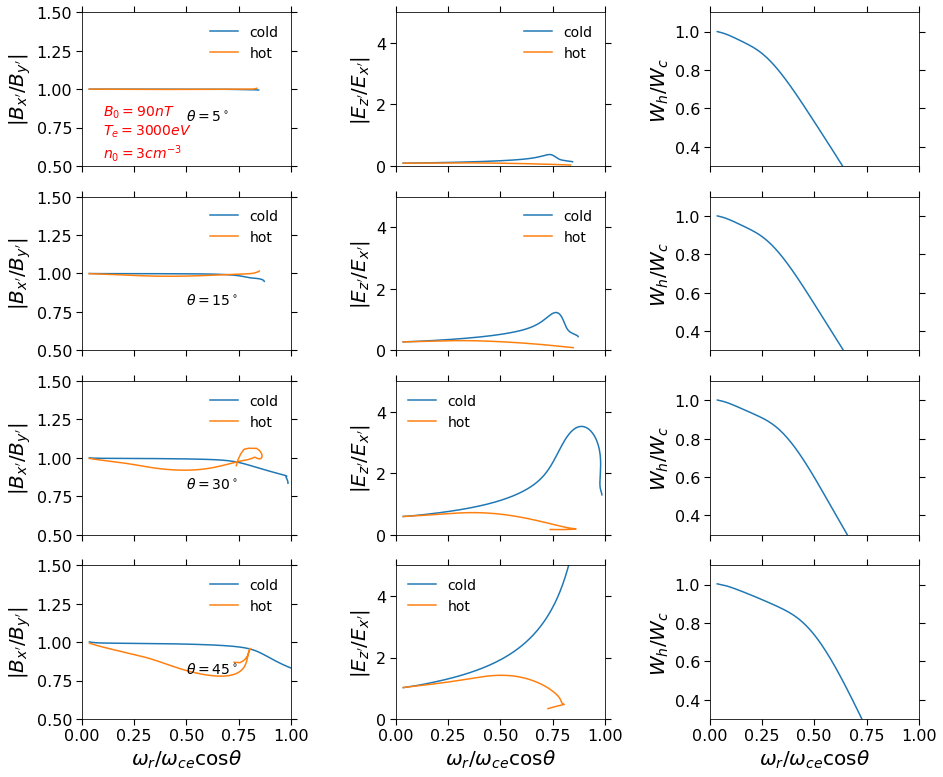

In [364]:
fig, axes = plt.subplots(4, 3, sharex=True, figsize = [15, 13], gridspec_kw={'wspace': .5})

theta_arr = [5, 15, 30, 45]

for i in range(4):
    
    cold_file = 'data/whistler_cold_hot/whistler_cold_b90_te3000_n3_theta_{0}.npy'.format(theta_arr[i])
    hot_file = 'data/whistler_cold_hot/whistler_hot_b90_te3000_n3_theta_{0}.npy'.format(theta_arr[i])
    cold_data = np.load(cold_file)
    hot_data = np.load(hot_file)

    ax = axes[i][0]

    ax.plot(cold_data[1, :], cold_data[3, :], label = 'cold')
    ax.plot(hot_data[1, :], hot_data[3, :], label = 'hot')
    ax.legend(loc='best', frameon=False, fontsize = 14)
    ax.set_xlim([0, 1.])
    ax.set_ylim([0.5, 1.5])
    ax.set_ylabel(r'$|B_{x^\prime}/B_{y^\prime}|$')
    ax.text(.5, .8, r'$\theta = {}^\circ$'.format(temp_arr[i]), fontsize = 14)

    ax = axes[i][1]

    ax.plot(cold_data[1, :], cold_data[4, :], label = 'cold')
    ax.plot(hot_data[1, :], hot_data[4, :], label = 'hot')
    ax.legend(loc='best', frameon=False, fontsize = 14)
#     ax.set_xlim([0, 1])
    ax.set_ylim([0, 5])
    ax.set_ylabel(r'$|E_{z^\prime}/E_{x^\prime}|$') 

    ax = axes[i][2]
    cold_interp = interpolate.interp1d(cold_data[1, :], cold_data[4, :])
    max_w, min_w = max(cold_data[1, :]), min(cold_data[1, :])
    mask = (hot_data[1, :] > min_w) & (hot_data[1, :] < max_w)
    ax.plot(hot_data[1, mask], hot_data[4, mask] / cold_interp(hot_data[1, mask]))
    ax.set_ylabel(r'$W_{h}/W_{c}$')
    ax.set_ylim([0.3, 1.1])
    
axes[3][0].set_xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')
axes[3][1].set_xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')
axes[3][2].set_xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')


text = ''
text += r'$B_0=90nT$' + '\n'
text += r'$T_e={0}eV$'.format(te) + '\n'
text += r'$n_0=3cm^{-3}$'

axes[0][0].text(.1, .55, text, fontsize = 14, color = 'r')

# fig.savefig('figure/whistler_cold_hot_b90_te3000_n3_pol_panel.png')

In [ ]:
!open figure/whistler_cold_hot_b90_te3000_n3_pol_panel.png

In [429]:
temp_arr = [500, 1500, 3000]
theta_arr = [5, 15, 30, 45]

wr_arr = [[] for _ in range(len(theta_arr))]
whwc_arr = [[] for _ in range(len(theta_arr))]
wh_arr = [[] for _ in range(len(theta_arr))]
wc_arr = [[] for _ in range(len(theta_arr))]

for i in range(len(theta_arr)):
    for j in range(len(temp_arr)):
        cold_file = 'data/whistler_cold_hot/whistler_cold_b90_te{0}_n3_theta_{1}.npy'.format(temp_arr[j], theta_arr[i])
        hot_file = 'data/whistler_cold_hot/whistler_hot_b90_te{0}_n3_theta_{1}.npy'.format(temp_arr[j], theta_arr[i])
        cold_data = np.load(cold_file)
        hot_data = np.load(hot_file)
        cold_interp = interpolate.interp1d(cold_data[1, :], cold_data[4, :])
        max_w, min_w = max(cold_data[1, :]), min(cold_data[1, :])
        mask = (hot_data[1, :] > min_w) & (hot_data[1, :] < max_w)
        wr_arr[i].append(hot_data[1, mask])
        whwc_arr[i].append(hot_data[4, mask] / cold_interp(hot_data[1, mask]))
        
        wh_arr[i].append(hot_data[4, mask])
        wc_arr[i].append(cold_interp(hot_data[1, mask]))

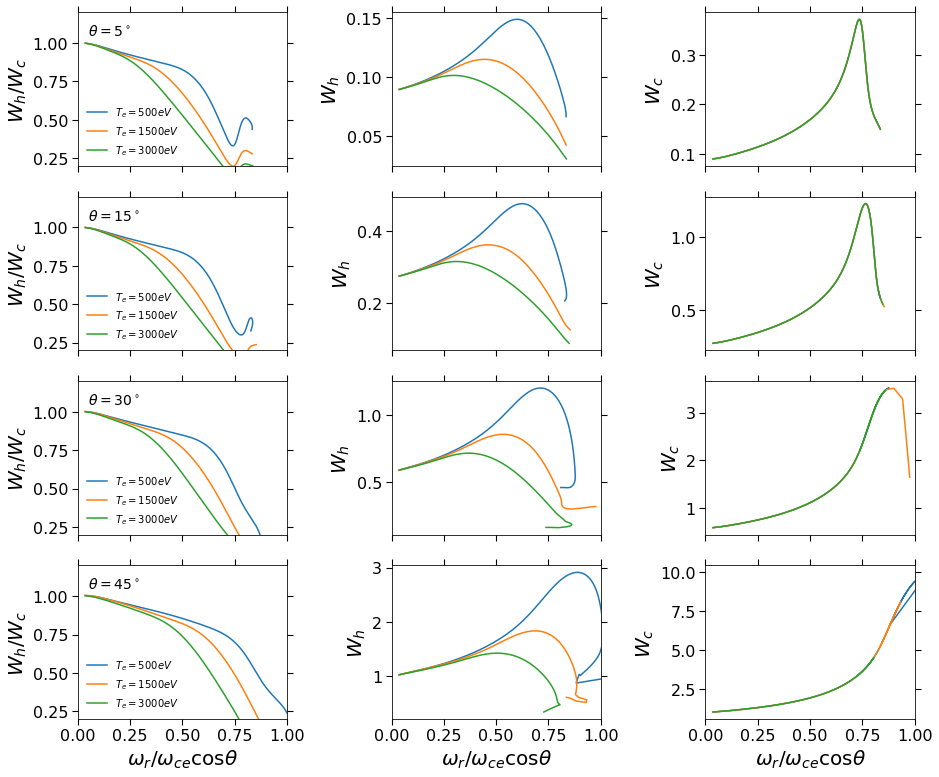

In [432]:
fig, axes = plt.subplots(len(theta_arr), 3, sharex=True, figsize=[15, 13], gridspec_kw={'wspace': .5})
for i in range(len(theta_arr)):
    ax = axes[i][0]
    for j in range(len(temp_arr)):
        ax.plot(wr_arr[i][j], whwc_arr[i][j], label=r'$T_e={}eV$'.format(temp_arr[j]))
    ax.legend(frameon=False)
    ax.set_ylabel(r'$W_h/W_c$')
    ax.text(0.05, 1.05, r'$\theta={}^\circ$'.format(theta_arr[i]), fontsize=14)
    ax.set_xlim([0, 1])
    ax.set_ylim([0.2, 1.2])
    
    ax = axes[i][1]
    for j in range(len(temp_arr)):
        ax.plot(wr_arr[i][j], wh_arr[i][j], label=r'$T_e={}eV$'.format(temp_arr[j]))
        ax.set_ylabel(r'$W_h$')

    ax = axes[i][2]
    for j in range(len(temp_arr)):
        ax.plot(wr_arr[i][j], wc_arr[i][j], label=r'$T_e={}eV$'.format(temp_arr[j]))
        ax.set_ylabel(r'$W_c$')
        
axes[len(theta_arr)-1][0].set_xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')
axes[len(theta_arr)-1][1].set_xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')
axes[len(theta_arr)-1][2].set_xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')

    
# fig.savefig('figure/whistler_cold_hot_b90_wave_energy_ratio_panel.png')
plt.show()


In [433]:
!open figure/whistler_cold_hot_b90_wave_energy_ratio_panel.png

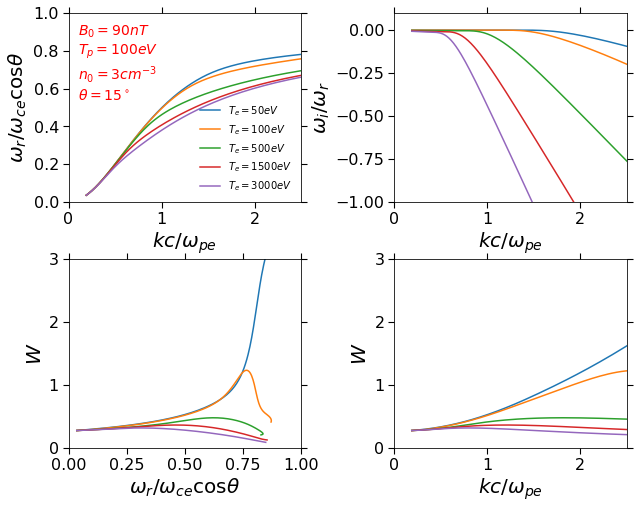

In [522]:
temp_arr = [50, 100, 500, 1500, 3000]
fig, axes = plt.subplots(2, 2, figsize=[10, 8], gridspec_kw={'wspace': .4, 'hspace': .3})

ax = axes[0][0]
for i in range(len(temp_arr)):
    hot_file = 'data/whistler_cold_hot/whistler_hot_b90_te{0}_n3_theta_15.npy'.format(temp_arr[i])
    hot_data = np.load(hot_file)
    ax.plot(hot_data[0, :], hot_data[1, :], label=r'$T_e={}eV$'.format(temp_arr[i]))
ax.set_ylabel(r'$\omega_r/\omega_{ce}\cos\theta$')
ax.legend(frameon=False)
ax.set_xlim([0, 2.5])
ax.set_ylim([0, 1])
ax.set_xlabel(r'$kc/\omega_{pe}$')

ax = axes[0][1]
for i in range(len(temp_arr)):
    hot_file = 'data/whistler_cold_hot/whistler_hot_b90_te{0}_n3_theta_15.npy'.format(temp_arr[i])
    hot_data = np.load(hot_file)
    ax.plot(hot_data[0, :], hot_data[2, :]/hot_data[1, :], label=r'$T_e={}eV$'.format(temp_arr[i]))
# ax.legend(frameon=False)
ax.set_ylabel(r'$\omega_i/\omega_r$')
ax.set_xlim([0, 2.5])
ax.set_ylim([-1, 0.1])
ax.set_xlabel(r'$kc/\omega_{pe}$')

ax = axes[1][0]
for i in range(len(temp_arr)):
    hot_file = 'data/whistler_cold_hot/whistler_hot_b90_te{0}_n3_theta_15.npy'.format(temp_arr[i])
    hot_data = np.load(hot_file)
    ax.plot(hot_data[1, :], hot_data[4, :], label=r'$T_e={}eV$'.format(temp_arr[i]))
ax.set_ylabel(r'$W$')
# ax.legend(frameon=False)
ax.set_xlim([0, 1])
ax.set_ylim([0, 3])
ax.set_xlabel(r'$\omega_r/\omega_{ce}\cos\theta$')

ax = axes[1][1]
for i in range(len(temp_arr)):
    hot_file = 'data/whistler_cold_hot/whistler_hot_b90_te{0}_n3_theta_15.npy'.format(temp_arr[i])
    hot_data = np.load(hot_file)
    ax.plot(hot_data[0, :], hot_data[4, :], label=r'$T_e={}eV$'.format(temp_arr[i]))
# ax.legend(frameon=False)
ax.set_ylabel(r'$W$')
ax.set_xlim([0, 2.5])
ax.set_ylim([0, 3])
ax.set_xlabel(r'$kc/\omega_{pe}$')
# ax.get_yaxis().set_ticklabels([])

text = ''
text += r'$B_0=90nT$' + '\n'
text += r'$T_p={0}eV$'.format(tp) + '\n'
text += r'$n_0=3cm^{-3}$' + '\n'
text += r'$\theta=15^\circ$'

axes[0][0].text(.1, .55, text, fontsize = 14, color = 'r')

# fig.savefig('figure/whistler_wave_energy_ratio_panel.png')